In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import torch.optim as optim
from IPython.core.debugger import set_trace
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
      
print(device)

GPU is available
cuda


In [3]:
base_csv = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Analysing sentiment

### Tokenization

In [4]:
stop_words = list(set(stopwords.words('english')))

In [5]:
def preprocess_string(s):
    s = s.lower()
    s = ' '.join([word for word in s.split() if word not in stop_words])
    # replace <br /><br /> with nothing
    s = re.sub('<[^>]+>', '', s)
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", ' ', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", ' ', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    
    # remove single characters
    s = ' '.join(list(filter(lambda x: len(x)!=1, s.split())))
    

    return s

In [6]:
df.loc[:, 'review'] = df.loc[:, 'review'].apply(preprocess_string)

In [7]:
complete = ' '.join(df['review'].tolist()).split()
counter = Counter(complete)
# words like could, would could be removed.
most_occur = counter.most_common(4)


In [8]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


In [9]:
np.__version__

'1.18.2'

In [10]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:2000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [11]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

In [12]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 2000


### Analysing review length

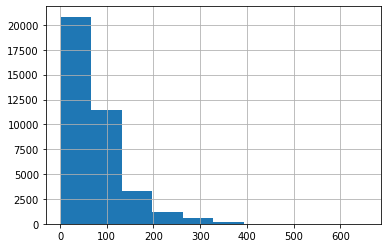

count    37500.000000
mean        80.666533
std         56.581712
min          2.000000
25%         46.000000
50%         62.000000
75%         98.000000
max        654.000000
dtype: float64

In [13]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [14]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            #features[ii, -len(review):] = np.array(review)[:seq_len]
            features[ii, :len(review)] = np.array(review)[:seq_len]
    return features

In [15]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = torch.tensor(padding_(x_train,200))
x_test_pad = torch.tensor(padding_(x_test,200))
x_train_pad.shape, x_test_pad.shape

(torch.Size([37500, 200]), torch.Size([12500, 200]))

In [16]:
np.array([[1,2,3], [4,5]])

array([list([1, 2, 3]), list([4, 5])], dtype=object)

In [17]:
x_train_pad[0]

tensor([ 285,    1,   21,   25,  268,   51,   72,  138,   16,   36,   30,  834,
         464,  198,    1,   22,  667,   30,   69,  234, 1614,   37,   31, 1822,
        1663,   12,   15,  897,  838,  236,  256,    2,  178, 1007, 1549, 1160,
         359,   11,  277,    2,  618, 1585,  110,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

### Model

In [18]:
def get_masks(padded):
    B, T = padded.shape
    mask = torch.eq(padded, 0).to(torch.float32)
    mask = mask * -1e9
    masked_reshape = mask.reshape(B, 1, T)
    return masked_reshape

train_mask = get_masks(x_train_pad)
val_mask = get_masks(x_test_pad)
print(train_mask.shape, val_mask.shape)

torch.Size([37500, 1, 200]) torch.Size([12500, 1, 200])


In [19]:
def get_angle(timesteps, dim):
    k = np.arange(dim)[np.newaxis, :]
    i = k // 2

    positions = np.arange(timesteps)[:, np.newaxis]
    angles = positions / (10000 ** (2*i/dim))

    return angles

def get_positional_embeddings(angles):
    angles[:, 0::2] = np.sin(angles[:, 0::2])
    angles[:, 1::2] = np.cos(angles[:, 1::2])

    return torch.tensor(angles, dtype=torch.float32)

In [20]:
class Embedding(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        self.embedding_layer = nn.Embedding(n_vocab, n_embed)
        
    def forward(self, x):
        return self.embedding_layer(x)

In [21]:
class Head(nn.Module):
    def __init__(self, head_size=16):
        super().__init__()
        self.query = nn.Linear(n_embed, head_size)
        self.key = nn.Linear(n_embed, head_size)
        self.value = nn.Linear(n_embed, head_size)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x, mask):
        B, T, C = x.shape
        
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        
        wei = query @ key.transpose(-2, -1)
        
        if mask is not None:
            wei = wei + mask
        
        wei = self.softmax(wei)
        out = wei @ value # (B, T, head_size)
        
        return out

In [22]:
class Encoder(nn.Module):
    def __init__(self, n_vocab, n_embed, timesteps, head_size, output):
        super().__init__() # What happens if I pass the class name in super?
        self.embedding = Embedding(n_vocab, n_embed)
        self.sa = Head(head_size)
        self.avgpool = nn.AvgPool1d(timesteps)
        self.inter1_layer = nn.Linear(head_size, head_size)
        self.output = nn.Linear(head_size, output)
        
    def forward(self, x, mask, positional_encoding):
        B, T = x.shape # validation shape --> (1000, 73)
#         print(self.embedding(x).shape, positional_encoding.shape)
        #set_trace()
        embedding = self.embedding(x) + positional_encoding # (B, timesteps, n_embed)
        sa_out = self.sa(embedding, mask) # (B, timesteps, head_size)
        averaged = self.avgpool(sa_out.permute(0, 2, 1)) # (B, head_size, 1)
        # implement average pooling after sa_out
        inter1 = self.inter1_layer(averaged.view(B, -1)) # (B, head_size) @ (head_size, head_size) --> (B, headsize)
        output = self.output(inter1) # (B, head_size) @ (head_size, output) --> (B, output)
        
        return output

In [23]:
def train_epoch(x_batch, mask, y_batch, positional_encoding):
    optimizer.zero_grad()
    output = model(x_batch, mask, positional_encoding)
    #set_trace()
    output = nn.Sigmoid()(output)
    
    
    loss = loss_function(output.view(-1), y_batch.view(-1))
    
    correct = 0
    correct += ((output.view(-1) > 0.5).float() == y_batch).float().sum()
    accuracy = correct / y_batch.shape[0]

    loss.backward()
    optimizer.step()
    
    return loss, accuracy

In [37]:
train_positional_encoding.shape, val_positional_encoding.shape

(torch.Size([200, 32]), torch.Size([200, 32]))

In [24]:
# At 2000 most common words and 200 padding, it outperformed LSTM slightly
n_embed = 32
timesteps = x_train_pad.shape[-1]
batch_size = 256
batch_per_epoch = x_train_pad.shape[0] // batch_size

train_padded, train_y = x_train_pad.to(device).long(), torch.tensor(y_train, dtype=torch.float).to(device)
val_padded, val_y = x_test_pad.to(device).long(), torch.tensor(y_test, dtype=torch.float).to(device) 
train_mask, val_mask = train_mask.to(device), val_mask.to(device)
train_positional_encoding = get_positional_embeddings(get_angle(timesteps, n_embed)).to(device)
val_positional_encoding = get_positional_embeddings(get_angle(val_padded.shape[-1], n_embed)).to(device)
print('Shape of encodings are', train_positional_encoding.shape, val_positional_encoding.shape)


model = Encoder(len(vocab)+1, n_embed, timesteps, head_size=n_embed, output=1).to(device)

loss_function = nn.BCELoss()
#loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


#model = nn.DataParallel(model, list(range(torch.cuda.device_count())))

Shape of encodings are torch.Size([200, 32]) torch.Size([200, 32])


In [25]:
def calculate_accuracy(outputs, labels):
    correct = 0
    #correct += (torch.argmax(F.softmax(outputs, dim=-1), dim=-1) == labels).float().sum()
    correct += ((outputs.view(-1) > 0.5).float() == labels).float().sum()
    return correct / labels.shape[0]

In [26]:
for epoch in range(0, 20):
    train_loss, val_loss = 0, 0
    training_accuracy = 0
    for i in range(batch_per_epoch):
        start = i * batch_size
        x_batch, y_batch, mask = train_padded[start:start+batch_size], train_y[start:start+batch_size], train_mask[start:start+batch_size]
#         x_batch, y_batch, mask = x_batch.to(device).long(), y_batch.to(device).long(), mask.to(device).long()

        model.train(True)
    
        loss, accuracy = train_epoch(x_batch, mask, y_batch, train_positional_encoding)
        train_loss += loss
        training_accuracy += accuracy
        
    print(f'Epoch {epoch} Loss: {train_loss / (i+1)}')
    print(f'Accuracy at Epoch {epoch} is {training_accuracy / (batch_per_epoch)}')
    
    model.eval()
    with torch.no_grad():
        output_val = model(val_padded, val_mask, val_positional_encoding)
        output_val = nn.Sigmoid()(output_val)
        
        loss_val = loss_function(output_val.view(-1), val_y.view(-1))
        
        accuracy = calculate_accuracy(output_val, val_y)
        
        print(f'Epoch {epoch} Val loss: {loss_val}')
        print(f'Accuracy at Epoch {epoch} is {accuracy}')
        
    print()

Epoch 0 Loss: 0.632503092288971
Accuracy at Epoch 0 is 0.6274614930152893
Epoch 0 Val loss: 0.5536753535270691
Accuracy at Epoch 0 is 0.7179999947547913

Epoch 1 Loss: 0.5229783654212952
Accuracy at Epoch 1 is 0.7367562055587769
Epoch 1 Val loss: 0.4897903501987457
Accuracy at Epoch 1 is 0.7653599977493286

Epoch 2 Loss: 0.45081162452697754
Accuracy at Epoch 2 is 0.7883668541908264
Epoch 2 Val loss: 0.43477100133895874
Accuracy at Epoch 2 is 0.798799991607666

Epoch 3 Loss: 0.397981196641922
Accuracy at Epoch 3 is 0.8205533027648926
Epoch 3 Val loss: 0.3953979015350342
Accuracy at Epoch 3 is 0.8200799822807312

Epoch 4 Loss: 0.3640466034412384
Accuracy at Epoch 4 is 0.8377301096916199
Epoch 4 Val loss: 0.3694131374359131
Accuracy at Epoch 4 is 0.8354399800300598

Epoch 5 Loss: 0.33946338295936584
Accuracy at Epoch 5 is 0.8517497777938843
Epoch 5 Val loss: 0.35347098112106323
Accuracy at Epoch 5 is 0.8447200059890747

Epoch 6 Loss: 0.3224619925022125
Accuracy at Epoch 6 is 0.86007064580

### Training

In [53]:
imp = list()

def hook_function(module, input, output):
    #set_trace()
    if not model.training:
        #set_trace()
        imp.append(output[0].tolist())

In [28]:
#handle.remove()
for name, layer in model.named_children():
    if name == 'sa':
        for sa_name, sa_layer in layer.named_children():
            if sa_name == 'softmax':
                print(sa_name)
                handle = sa_layer.register_forward_hook(hook_function)

softmax


In [38]:
def predict_text(text):
    #set_trace()
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                     if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding_(word_seq,200))
    inputs = pad.to(device)
    test_mask = get_masks(inputs).to(device)
    batch_size = 1
    model.eval()
    #set_trace()
    output = model(inputs, test_mask, train_positional_encoding)
    output = nn.Sigmoid()(output)
    return output.item()

In [54]:
# 13000, 14000, 15000, 15100
index = 1 
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

wonderful little production the filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece the actors extremely well chosen michael sheen has got polari voices pat too truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life the realism really comes home little things fantasy guard which rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.9721733927726746


In [55]:
attn_imp = np.sum(np.array(imp)[0], axis=0)
cleaned_words = ' '.join([word for word in df.loc[index, 'review'].split() if preprocess_string(word) in vocab.keys()])
#colors = attn_imp * (255/np.max(attn_imp))
maxi = np.max(attn_imp); mini = np.min(attn_imp)
max_val, min_val = 255, 0
colors = min_val + (max_val - min_val) * (attn_imp - mini) / (maxi - mini)

for color, word in zip(colors.tolist(), cleaned_words.split()):
    if int(color) > 0:
        if int(color) < 50:
            r, g, b = 255, 255, 255
            print(f'\033[48;2;{int(r)};{g};{b}m{word}\033', end=' ')
        else:
            r, g, b = int(color), 0, 0
            print(f'\033[48;2;{r};{g};{b}m\033[97m{word}\033[0m', end=' ')

wonderful little production filming old time fashion gives sometimes sense realism entire piece actors extremely well michael got truly see editing references williams well worth watching written piece production one great master comedy life realism really comes home little things fantasy rather use dream remains solid plays knowledge particularly scenes sets particularly flat every terribly well done 

In [56]:
dummy = pd.read_csv(base_csv)
dummy['review'][index]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [ ]:
for r in list(range(160, 255, 5)):
    #print(f'\033[48;5;{r};1;1mthis\033')
    #print(f'\033[48;5;{r}mthis\033')
    gb = 40
    print(f'\033[48;2;{r};{gb};{gb}mthis {r}\033')

In [ ]:
maxi = np.max(attn_imp); mini = np.min(attn_imp)
max_val, min_val = 255, 0
print(min_val, max_val)
print(mini, maxi)

min_val + (max_val - min_val) * (attn_imp - mini) / (maxi - mini)

In [ ]:
def scale_array(array, min_value, max_value):
    min_array_value = min(array)
    max_array_value = max(array)
    scaled_array = []
    print(min_value, max_value)
    print(min_array_value, max_array_value)
    scaled_value = min_value + (max_value - min_value) * (array - min_array_value) / (max_array_value - min_array_value)
#     for value in array:
#         scaled_value = min_value + (max_value - min_value) * (value - min_array_value) / (max_array_value - min_array_value)
#         scaled_array.append(scaled_value)

    return scaled_value

# Example usage
array = attn_imp
min_value = 0
max_value = 255

scaled_array = scale_array(array, min_value, max_value)
print(scaled_array)  # Output: [0.0, 25.0, 50.0, 75.0, 100.0]
